# Nuclear segmentation with emerin ring and spot detection

Scripts to detect nuclei from 5d images (t,c,z,y,x) where channel 0 is green spots and channel 1 is red emerin rings.
Mostly based on scripts from Lucien Hinderling, with some modifications and cleanup by Jennifer Semple.

Nuclear segmentation carried out with Cellpose.
Spot detection carried out with pytrack.

**Inputs**:

raw_input_path and denoised_input_path for directories containing raw and denoised images and output_path where results will be put. raw_input_path is used to create a dataframe with paths to images and the following 
columns:

*filename	date	experiment	strain	protein	id  raw_filepath    denoised_filepath*

example line:

*20240915_1268_E_bean_15um	20240915	3d	1268	DPY27	DPY27_3d_20240915_1268_E_bean_15um	/mnt/external.data/MeisterLab/Dario/Imaging/DP...	/mnt/external.data/MeisterLab/Dario/Imaging/DP...*

the id column is used to name images in the output_path directories

**Outputs**:

segmentation masks (.tif files) in output_path/segmentation/

distance masks (.tif files) in output_path/edt/

nuclear measurements from middle slice of each nucleus (.csv files) in output_path/nuclei/

intensity measurements for nuclei with arrays of intensity/distance from middle slice of each nuclear mask (.pkl files) in output_path/dist/ 

qc plots of segmentation on original image (segmentation_XXX.pdf), individual masked nuclei (cropped_nuclei_XXX.pdf) in output_path/qc/

spot detection (.csv files, doesn't work very well) in output_path/spots/ with some qc in output_path/qc/spots*.pdf and spotGMM*.pdf

### Setting you might need to change

raw_input_path - should point to directory where the nd2 images are '/mnt/external.data/MeisterLab/Dario/Imaging/SDC1/1273/20241108_hs'. 
Scripts assume the denoised images are one level down in N2v_1268RG_1273RG/denoised foler.
Scripts assume that the directory above the raw_input drive contains strain name, and the directory above that contains protein name.

output_path - create a directory for the analysis. results will be stored in a protein/strain/date structure same as in the raw_input_path.

Make sure file paths end with  '/'


In [77]:
import napari
import torch
from skimage.measure import regionprops_table, regionprops
from skimage.color import label2rgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import cellpose
from cellpose import models
import edt
import glob
import os
import tqdm
from matplotlib_scalebar.scalebar import ScaleBar
import gc
import seaborn as sns
from sklearn.mixture import GaussianMixture
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter
import scipy.stats as stats
from scipy import optimize


#anisotropy = (3,1,1) # Relative scale of (Z,X,Y) axes now calculated inside scripts

nucChannel = 0 # red emerin rings
spotChannel = 1 # green spots
server = True # is the script running on the server or mounted on mac

def macMount(path): # tansforms server path to path for izbkingston mounted on mac
    newpath = path.replace('/mnt/','/Volumes/')
    return newpath

# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

pd.set_option('display.max_columns', None)

In [78]:
# on server
#raw_input_path = '/mnt/external.data/MeisterLab/Dario/DPY27/1268/20241107_hs/'
#raw_input_path = '/mnt/external.data/MeisterLab/Dario/SDC1/1273/20241108_hs/'
#raw_input_path = '/mnt/external.data/MeisterLab/Dario/DPY27/1268/20241010_tl/'
raw_input_path = '/mnt/external.data/MeisterLab/Dario/SDC1/1273/20241010_tl/'
# extract identifying directories from raw_input_path
protein_strain_date = '/'.join(os.path.normpath(raw_input_path).split(os.sep)[-3:])
output_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/'+protein_strain_date+'/'


if(not server):
    raw_input_path = macMount(raw_input_path)
    output_path = macMount(output_path)

denoised_input_path = raw_input_path+'N2V_sdc1_dpy27_mSG_emr1_mCh/denoised/'


if not os.path.exists(output_path+"/qc"):
    os.makedirs(output_path+"/qc")

if not os.path.exists(output_path+"/segmentation"):
    os.makedirs(output_path+"/segmentation")

if not os.path.exists(output_path+"/edt"):
    os.makedirs(output_path+"/edt")

if not os.path.exists(output_path+"/spots"):
    os.makedirs(output_path+"/spots")

if not os.path.exists(output_path+"/nuclei"):
    os.makedirs(output_path+"/nuclei")

if not os.path.exists(output_path+"/dist"):
    os.makedirs(output_path+"/dist")


raw_file_name_pattern = "/*.nd2"
denoised_file_name_pattern = "/*_n2v.tif"
raw_filepaths = sorted(glob.glob(raw_input_path + raw_file_name_pattern,recursive=True))
raw_filepaths = [filepath for filepath in raw_filepaths if '_bad.nd2' not in filepath]

print(f"Found {len(raw_filepaths)} *.nd2 files.")

Found 2 *.nd2 files.


Generate data frame of file paths with metadata

In [79]:
if(server): #only save if running on server
    df = pd.DataFrame()
    df['filename'] = [os.path.basename(filepath)[:-4] for filepath in raw_filepaths]
    tmpdate = [os.path.normpath(filepath).split(os.sep)[-2] for filepath in raw_filepaths]
    df['date'] = pd.Series([exp.split('_')[0] for exp in tmpdate])
    df['experiment'] = pd.Series([exp.split('_')[1] for exp in tmpdate])
    df['strain'] = [os.path.normpath(filepath).split(os.sep)[-3] for filepath in raw_filepaths]
    df['protein'] = [os.path.normpath(filepath).split(os.sep)[-4] for filepath in raw_filepaths]
    df['id'] = df['protein'] + '_' + df['experiment'] + '_' + df['filename'] 
    df['raw_filepath'] = raw_filepaths
    df['denoised_filepath'] = [denoised_input_path+filename+'_n2v.tif' for filename in df['filename']]
    df.to_csv(output_path+'fileList.csv',index=False)
else:
    df=pd.read_csv(output_path+'fileList.csv')
    for i in range(len(df)):
        df.at[i,'raw_filepath'] = macMount(df.at[i,'raw_filepath'])
        df.at[i,'denoised_filepath'] = macMount(df.at[i,'denoised_filepath'])


df

,filename,date,experiment,strain,protein,id,raw_filepath,denoised_filepath
0,20241010_1273_E_early_3h_5min_5um,20241010,tl,1273,SDC1,SDC1_tl_20241010_1273_E_early_3h_5min_5um,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
1,20241010_1273_E_early_3h_5min_5um_03,20241010,tl,1273,SDC1,SDC1_tl_20241010_1273_E_early_3h_5min_5um_03,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...


Load model

In [80]:
torch.cuda.device(0)
model_path='/mnt/external.data/MeisterLab/lhinder/segmentation_3d_anja/code/worms_1000epochs_v0'
if(not server):
    model_path = macMount(model_path)

if torch.cuda.is_available():
    print("GPU is available")
    model = models.CellposeModel(pretrained_model=model_path, gpu=True, device =torch.device('cuda:0'))
else:
    print("Only CPU is available")
    model = models.CellposeModel(pretrained_model=model_path, gpu=False)


# no gpu, from local machine with izbkingston mounted 
#model = models.CellposeModel(pretrained_model='/Volumes/external.data/MeisterLab/lhinder/segmentation_3d_anja/code/worms_1000epochs_v0')

Only CPU is available


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fi

## Functions for nuclear segmentation and qc

In [81]:
# Disable do_3D, there is a bug. 2D and stitching with overlap works much better.
# Takes around 7min for the whole image on the macbook
def segment_nuclei(img, model):
    ''' use pytorch cellpose model to segment nuclei'''
    masks,flows,styles = model.eval(img,do_3D=False,stitch_threshold=0.3,cellprob_threshold =0,diameter =36)
    return masks,flows,styles


def calc_distance_mask(masks,anisotropy):
    '''Calculate the distance map from the nuclei-edge towards the center of nucleus'''
    masks_edt = edt.edt(masks,anisotropy = anisotropy)
    return masks_edt


def plot_qc_nuclei_crop(df, index, df_region_props, img, t=0, display = False, seed=1):
    '''Plot a cropped region of a random sample of 10 nuclei from each image'''
    nb_nuc = 10
    np.random.seed(seed)
    indices_to_sample = np.random.choice(range(len(df_region_props)),size = nb_nuc,replace = False)
    # sort indeces in descending order of area

    widths=[df_region_props['image'][i].shape[1] for i in indices_to_sample]

    fig, axs = plt.subplots(nrows = 2, ncols = nb_nuc, figsize = (15,5),dpi = 250, 
                            sharex=False, sharey=False, width_ratios=widths)
    fig.suptitle(f'Cropped nuclei {df.id.iloc[index]}', fontsize=16)

    for i,sample in enumerate(indices_to_sample):
        intensity_image = df_region_props['intensity_image'][sample][:,:,:,spotChannel] #show first spot channel
        image = df_region_props['image'][sample]
        mx = np.ma.masked_array(intensity_image,mask = ~image)
        z_height = image.shape[0] 
        axs[0,i].imshow(mx[int(z_height/2)])
        axs[0,i].spines['top'].set_visible(False)
        axs[0,i].spines['right'].set_visible(False)
        axs[0,i].spines['bottom'].set_visible(False)
        axs[0,i].spines['left'].set_visible(False)
        axs[0,i].get_xaxis().set_ticks([])
        axs[0,i].get_yaxis().set_ticks([])

    for i,sample in enumerate(indices_to_sample):
        intensity_image = df_region_props['intensity_image'][sample][:,:,:,nucChannel] #show second nuclear channel
        image = df_region_props['image'][sample]
        mx = np.ma.masked_array(intensity_image,mask = ~image)
        z_height = image.shape[0]
        axs[1,i].imshow(mx[int(z_height/2)])
        axs[1,i].spines['top'].set_visible(False)
        axs[1,i].spines['right'].set_visible(False)
        axs[1,i].spines['bottom'].set_visible(False)
        axs[1,i].spines['left'].set_visible(False)
        axs[1,i].get_xaxis().set_ticks([])
        axs[1,i].get_yaxis().set_ticks([])

        if i == nb_nuc-1:
            scalebar = ScaleBar(0.065, "um", length_fraction=1, box_alpha=0.7,color='black',location='lower right',height_fraction = 0.05,border_pad =-1)
            axs[1,i].add_artist(scalebar)

    #plt.tight_layout()
    fig.savefig(output_path + 'qc/cropped_nuclei_'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.pdf')
    if display == False:
        plt.close()
    else:
        plt.show()


def plot_single_nucleus_crop(df, index, df_region_props, nuc_index, img):
    '''Plot a cropped region of a particular nucleus'''

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (3,1.5),dpi = 250, sharey=True)
    fig.suptitle(f'{df.id.iloc[index]}', fontsize=6)

    intensity_image = df_region_props['intensity_image'][nuc_index][:,:,:,spotChannel] #show first spot channel
    image = df_region_props['image'][nuc_index]
    mx = np.ma.masked_array(intensity_image, mask = ~image)
    z_height = image.shape[0] 
    axs[0].imshow(mx[int(z_height/2)])
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].get_xaxis().set_ticks([])
    axs[0].get_yaxis().set_ticks([])


    intensity_image = df_region_props['intensity_image'][nuc_index][:,:,:,nucChannel] #show second nuclear channel
    image = df_region_props['image'][nuc_index]
    mx = np.ma.masked_array(intensity_image, mask = ~image)
    z_height = image.shape[0]
    axs[1].imshow(mx[int(z_height/2)])
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].get_xaxis().set_ticks([])
    axs[1].get_yaxis().set_ticks([])


    scalebar = ScaleBar(0.065, "um", length_fraction=1, box_alpha=0.7,color='black',location='lower right',height_fraction = 0.05,border_pad =-1)
    axs[1].add_artist(scalebar)

    plt.show()


def plot_qc_segmentation_xyz(img, masks, index, df, t=0, display_plot=False, plotContours=False):
    '''Plot a 2x3 grid of xy, xz, yz slices of the image and the corresponding segmentation'''
    nucChannel = 0
    num_z=img.shape[1]
    num_y=img.shape[2]
    num_x=img.shape[3]
    nlabel=100

    fig = plt.figure(layout='constrained',dpi=450,figsize = (10,10))
    fig.suptitle(f'Segmentation for {df.id.iloc[index]}', fontsize=10)
    subfigs = fig.subfigures(2, 1, wspace=0.1)

    axsTop = subfigs[0].subplots(2, 3,sharex=True, sharey=True)
    #xy
    axsTop[0,0].imshow(label2rgb(masks[int(num_z*0.3),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,0].set_title('z='+str(int(num_z*0.3)), fontsize=8)
    axsTop[0,1].imshow(label2rgb(masks[int(num_z*0.5),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,1].set_title('z='+str(int(num_z*0.5)), fontsize=8)
    axsTop[0,2].imshow(label2rgb(masks[int(num_z*0.7),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,2].set_title('z='+str(int(num_z*0.7)), fontsize=8)

    axsTop[1,0].imshow(img[nucChannel,int(num_z*0.3),:,:],cmap = 'gray_r')
    axsTop[1,1].imshow(img[nucChannel,int(num_z*0.5),:,:],cmap = 'gray_r')
    axsTop[1,2].imshow(img[nucChannel,int(num_z*0.7),:,:],cmap = 'gray_r')

    if plotContours:
        axsTop[1,0].contour(masks[int(num_z*0.3),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,1].contour(masks[int(num_z*0.5),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,2].contour(masks[int(num_z*0.7),:,:], [0.5], linewidths=0.5, colors='r')



    for axss in axsTop:
        for ax in axss:
            #ax.set_xlim(0,num_x)
            #ax.set_ylim(0,num_y)
            ax.set_xticks([])
            ax.set_yticks([])

    axsBottom = subfigs[1].subplots(4, 3,sharex=True,sharey=True)
    #xz
    axsBottom[0,0].imshow(label2rgb(masks[:,int(num_y*0.3),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,0].set_title('y='+str(int(num_y*0.3)), fontsize=8)
    axsBottom[0,1].imshow(label2rgb(masks[:,int(num_y*0.5),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,1].set_title('y='+str(int(num_y*0.5)), fontsize=8)
    axsBottom[0,2].imshow(label2rgb(masks[:,int(num_y*0.7),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,2].set_title('y='+str(int(num_y*0.7)), fontsize=8)

    axsBottom[1,0].imshow(img[nucChannel,:,int(num_y*0.3),:],cmap = 'gray_r')
    axsBottom[1,1].imshow(img[nucChannel,:,int(num_y*0.5),:],cmap = 'gray_r')
    axsBottom[1,2].imshow(img[nucChannel,:,int(num_y*0.7),:],cmap = 'gray_r')

    if plotContours:
        axsBottom[1,0].contour(masks[:,int(num_y*0.3),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,1].contour(masks[:,int(num_y*0.5),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,2].contour(masks[:,int(num_y*0.7),:], [0.5], linewidths=0.5, colors='r')


    #yz
    axsBottom[2,0].imshow(label2rgb(masks[:,:,int(num_x*0.3)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,0].set_title('x='+str(int(num_x*0.3)), fontsize=8)
    axsBottom[2,1].imshow(label2rgb(masks[:,:,int(num_x*0.5)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,1].set_title('x='+str(int(num_x*0.5)), fontsize=8)
    axsBottom[2,2].imshow(label2rgb(masks[:,:,int(num_x*0.7)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,2].set_title('x='+str(int(num_x*0.7)), fontsize=8)

    axsBottom[3,0].imshow(img[nucChannel,:,:,int(num_x*0.3)],cmap = 'gray_r')
    axsBottom[3,1].imshow(img[nucChannel,:,:,int(num_x*0.5)],cmap = 'gray_r')
    axsBottom[3,2].imshow(img[nucChannel,:,:,int(num_x*0.7)],cmap = 'gray_r')

    if plotContours:
        axsBottom[3,0].contour(masks[:,:,int(num_x*0.3)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,1].contour(masks[:,:,int(num_x*0.5)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,2].contour(masks[:,:,int(num_x*0.7)], [0.5], linewidths=0.5, colors='r')

    for axss in axsBottom:
        for ax in axss:
            #ax.set_ylim(0,num_z)
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    if display_plot:
        plt.show()
    else:
        fig.savefig(output_path + 'qc/segmentation_'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.png')
        plt.close()

In [82]:
## Run the segmentation script on all images (reserve more than 24GB!)
# this produces segmentation, segmentation_qc and edt files
def run_nuclear_segmentation(indices, df, rerun=False):
    '''Run the segmentation on all images in the dataframe'''
    for index in tqdm.tqdm(indices):
        if rerun or not os.path.exists(output_path+'edt/'+df.id.iloc[index]+'_t0.tif'):
            # get anisotropy from raw image metadata
            img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
            ZvX = np.round(img_5d.physical_pixel_sizes.Z/img_5d.physical_pixel_sizes.X,0)
            anisotropy = (ZvX,1,1)
            # Load the denoised data
            img_5d = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
            for t in range(img_5d.dims.T):
                img = img_5d.get_image_data("CZYX", T=t)

                # Segment nuclei 
                masks,flows,styles = segment_nuclei(img[nucChannel,:,:,:],model) # Run the segmentation
                plot_qc_segmentation_xyz(img,masks,index, df, t, display_plot = False)                         # Create qc plot
                OmeTiffWriter.save(masks, output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif')

                del flows
                del styles
                gc.collect()
                
                # Calculate edt 
                masks_edt = calc_distance_mask(masks,anisotropy)
                OmeTiffWriter.save(masks_edt, output_path+'edt/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif')

                del masks
                del masks_edt
                gc.collect()
                continue


## Functions for autocorrelation

In [83]:
def get_nuc_background_image_mask(img, i, df_region_props, spotChannel):
    '''
    Uses bounding box for nucleus and the original image to extract
    intensity values and mask for background pixels close to the nucleus.
    '''
    z1 = df_region_props['bbox-0'].iloc[i]
    z2 = df_region_props['bbox-3'].iloc[i]
    y1 = df_region_props['bbox-1'].iloc[i]
    y2 = df_region_props['bbox-4'].iloc[i]
    x1 = df_region_props['bbox-2'].iloc[i]
    x2 = df_region_props['bbox-5'].iloc[i]
    #print(z1,z2,y1,y2,x1,x2)
    if z2==z1:
        mskd = np.ma.masked_array(img[z1,y1:y2,x1:x2,spotChannel], mask = df_region_props['image'].iloc[i],fill_value=0)
    else:
        mskd = np.ma.masked_array(img[z1:z2,y1:y2,x1:x2,spotChannel], mask = df_region_props['image'].iloc[i],fill_value=0)
    bg_image = mskd.data
    bg_image[mskd.mask] = 0 # remove unwanted data to save space
    # note that in masked arrays True is invalid data, so need to reverse logic of mask
    bg_mask = np.logical_not(mskd.mask)
    return(bg_image, bg_mask)

In [84]:
def center_image_values(image,image_mask):
    '''
    Centers image values around the mean, taking
    into account a mask, and zeros the masked region.
    '''
    norm_image=image-image[image_mask].mean()
    norm_image[np.logical_not(image_mask)] = 0
    return(norm_image)



def get_autocorrelation_2d(img,img_mask,maxr=12):
    '''
    Calculates autocorrelation function for a single
    2-3d image with a mask, according to
    Munschi et al. 2025, with additional normalisation
    steps.
    '''
    xdim = img.shape[2]
    ydim = img.shape[1]
    zdim = img.shape[0]
    norm_img = center_image_values(img,img_mask)
    yautocorr = np.zeros((ydim))
    for x in range(0,xdim):
        for z in range(0,zdim):
            result = np.correlate(norm_img[z,:,x],norm_img[z,:,x],mode='full')
            yautocorr=yautocorr + result[result.size//2:]
    
    xautocorr = np.zeros((xdim))
    for y in range(0,ydim):
        for z in range(0,zdim):
            result = np.correlate(norm_img[z,y,:],norm_img[z,y,:],mode='full')
            xautocorr=xautocorr + result[result.size//2:]
    if(xdim>=ydim):
        yautocorr = np.pad(yautocorr,(0,xdim-ydim))
    elif(ydim>xdim):
        xautocorr = np.pad(xautocorr,(0,ydim-xdim))
    autocorr = (xautocorr+yautocorr)/2
    # normalise by number of pixels and overall variance of image
    validPixels=np.sum(img_mask)
    pixelNorm = autocorr/validPixels #autocorr/(validPixels*(validPixels-1)/2) # is it only one dimensional because doing x and y separately?
    varNorm = pixelNorm/np.var(norm_img[img_mask])
    return(varNorm[1:maxr])

def exponential_decay(x, a, b,c):
    '''
    Exponenetial decay function for autocorrelation
    according to Munschi et al. 2025.
    '''                           
    return a + b * np.exp(-c * x)      

def fit_acf(autocorr):
    '''
    Fits parameters of an exponential decay function 
    to the autocorrelation values. Used for single
    nuclei.
    '''
    x=range(1,autocorr.size+1)
    initialguess = [0.01, 0.1, 0.1]
    try:
        fit, covariance = optimize.curve_fit(           
            exponential_decay,                                     
            x,   
            autocorr,#np.insert(autocorr,0,1),    
            initialguess) 
    except RuntimeError:
        fit = [np.nan, np.nan, np.nan]
        covariance = np.zeros((3,3))     
    return(fit, covariance)


def fit_acf_sd(autocorr,std):
    '''
    Fits parameters of an exponential decay function 
    to the autocorrelation values, taking into
    account the standard deviation of the values.
    Used for multiple nuclei from single image.
    '''
    x=range(1,autocorr.size+1)
    initialguess = [0.01, 0.1, 0.1]
    try:
        fit, covariance = optimize.curve_fit(           
            exponential_decay,                                     
            x,   
            autocorr,#np.insert(autocorr,0,1),    
            initialguess,
            sigma=std,
            absolute_sigma=True)
    except RuntimeError:
        fit = [np.nan, np.nan, np.nan]
        covariance = np.zeros((3,3))
    return(fit, covariance)


def correlation_length(fit):
    '''
    Calculates correlation length according to
    Munschi et al. 2025.
    '''
    if np.nan not in fit:
        c=fit[2]
        x0=1
        lam=x0+np.log(2)/c
    else: 
        lam = np.nan
    return(lam)


def correlation_error(fit,cov):
    '''
    Calculates correlation length error according to
    Munschi et al. 2025.
    '''
    if np.nan not in fit:
        c=fit[2]
        sigma_c = np.sqrt(cov[2,2])
        lam = correlation_length(fit)
        lam_error = lam*sigma_c/c
    else:
        lam_error = np.nan
    return(lam_error)


def get_autocorrelation_length(img,mask):
    '''
    Calculates autocorelation length from 
    a 2d or 3d image and mask. 
    '''
    ac = get_autocorrelation_2d(img,mask)
    fit, cov=fit_acf(ac)
    if np.nan not in fit:
        ac_length = correlation_length(fit)
        ac_error = correlation_error(fit,cov)
    else:
        ac_length = np.nan
        ac_error = np.nan
    return(ac, ac_length, ac_error)


def get_mean_autocorrelation_length(acf_matrix):
    '''
    Calculates autocorrelation length from matrix of ACF 
    (each row is a single nucleus ACF)
    '''
    acf_mean = acf_matrix[~np.isnan(acf_matrix[:,1])].mean(axis=0)
    acf_std = acf_matrix[~np.isnan(acf_matrix[:,1])].std(axis=0)
    fit, cov=fit_acf_sd(acf_mean,acf_std)
    if np.nan not in fit:
        lam = correlation_length(fit)
        lam_error = correlation_error(fit, cov)
    else:
        lam = np.nan
        lam_error = np.nan
    return(acf_mean, acf_std, lam, lam_error, fit)

In [85]:
## read images
## crop the nuclei slices
## calculate EDT transform
## for each nuclei loop over all distances (1:40) and take mean
## array of distance/intensity measurements are taken only for middle slice of mask (?)

## nucleus_id | nucleus volume | [1:20] mean intensities | group | ...
#indices=range(0,len(df))
#run_dist_analysis(indices, df)

def run_dist_analysis(indices,df):
    '''Run the distance analysis on all images in the dataframe'''
    for index in tqdm.tqdm(indices):
        print(df.iloc[index].raw_filepath)
        img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
        # calculate anisotropy from raw image metadata
        ZvX = np.round(img_5d.physical_pixel_sizes.Z/img_5d.physical_pixel_sizes.X,0)
        df_nuclei_all = pd.DataFrame()
        for t in range(img_5d.dims.T):
            print(t)
            df_nuclei = pd.DataFrame()
            img = img_5d.get_image_data("ZYXC", T=t)

            masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
            masks = masks.get_image_data("ZYX", T=0, C=0)
            
            df_region_props = regionprops_table(masks,img, properties = ['label', 'bbox', 'area','centroid','MajorAxisLength','solidity','image','intensity_image'])
            df_region_props = pd.DataFrame(df_region_props)

            if len(df_region_props)>=10:
                plot_qc_nuclei_crop(df, index, df_region_props, img, t=t, display = False) 
            
            if len(df_region_props)>=1:
                for i in range(len(df_region_props)):
                    df_nuclei_temp = pd.DataFrame()

                    intensity_image_spots = df_region_props['intensity_image'].iloc[i][:,:,:,spotChannel] #show spot channel
                    intensity_image_nuclei = df_region_props['intensity_image'].iloc[i][:,:,:,nucChannel] #show nuclear ring channel

                    image = df_region_props['image'][i]  # binary 3d mask

                    # Extract the intensity per distance
                    mx_spots = np.ma.masked_array(intensity_image_spots, mask = ~image) # 3d masked spot channel
                    mx_nuclei = np.ma.masked_array(intensity_image_nuclei,mask = ~image) # 3d masked nuclear ring channel
                    mx_mask = np.ma.masked_array(image,mask = ~image)  # 3d masked binary mask

                    z_height = image.shape[0]

                    slice_spots = mx_spots[int(z_height/2)]
                    slice_nuclei = mx_nuclei[int(z_height/2)]
                    slice_mask = mx_mask[int(z_height/2)]

                    slice_mask_edt = edt.edt(slice_mask)
                    slice_mask_edt = np.ma.masked_array(slice_mask_edt, mask = ~(slice_mask_edt>0)) 

                    results = regionprops_table(slice_mask_edt.astype('int'),slice_nuclei,properties=['label','intensity_mean'])
                    intensity_dist_nuclei = results['intensity_mean']

                    results = regionprops_table(slice_mask_edt.astype('int'),slice_spots,properties=['label','intensity_mean'])
                    intensity_dist_spots = results['intensity_mean']

                    dist = results['label']

                    #background pixels for from bounding box of nucleus
                    bg_image, bg_mask = get_nuc_background_image_mask(img, i, df_region_props, spotChannel)

                    df_nuclei_temp =  pd.DataFrame([df_region_props.iloc[i]])
                    df_nuclei_temp.rename(columns = {"centroid-0": "centroid_z", "centroid-1": "centroid_y", "centroid-2": "centroid_x",
                                                    "MajorAxisLength": "major_axis_length"}, inplace = True)
                    df_nuclei_temp['intensity_background'] = [bg_image]
                    df_nuclei_temp['mask_background'] = [bg_mask]
                    df_nuclei_temp['bb_dimZ']  = [mx_spots.shape[0]]
                    df_nuclei_temp['bb_dimY']  = [mx_spots.shape[1]]
                    df_nuclei_temp['bb_dimX']  = [mx_spots.shape[2]]
                    df_nuclei_temp['mean'] = [np.ma.mean(mx_spots)]
                    df_nuclei_temp['median'] = [np.ma.median(mx_spots)]
                    df_nuclei_temp['std']=  [np.ma.std(mx_spots)]
                    df_nuclei_temp['sum']= [np.ma.sum(mx_spots)]
                    df_nuclei_temp['variance']= [np.ma.var(mx_spots)]
                    df_nuclei_temp['max'] = [np.ma.max(mx_spots)]
                    df_nuclei_temp['min'] = [np.ma.min(mx_spots)]
                    df_nuclei_temp['volume'] = [np.sum(np.invert(mx_spots.mask))]
                    df_nuclei_temp['mean_background'] = [bg_image[bg_mask].mean()]
                    df_nuclei_temp['std_background'] = [bg_image[bg_mask].std()]
                    df_nuclei_temp['sum_background'] = [bg_image[bg_mask].sum()]
                    df_nuclei_temp['volume_background'] = [bg_mask.sum()]
                    df_nuclei_temp['id'] = [df.id.iloc[index]]
                    df_nuclei_temp['timepoint'] = [t]
                    df_nuclei_temp['intensity_dist_nuclei'] = [intensity_dist_nuclei]  # this is the emerin ring channel intensity on central slice
                    df_nuclei_temp['intensity_dist_spots'] = [intensity_dist_spots] # this is the spot channel but not actual detected spots
                    df_nuclei_temp['intensity_dist'] = [dist]  # this is the distance from the edge of the nucleus
                    df_nuclei_temp['zproj_spots'] = [np.max(intensity_image_spots[:,:,:], axis = 0)]
                    df_nuclei_temp['zproj_nuclei'] = [np.max(intensity_image_nuclei[:,:,:], axis = 0)]
                    df_nuclei_temp['zproj_background'] = [np.max(bg_image[:,:,:], axis = 0)]
                    df_nuclei_temp['anisotropy'] = [ZvX]

                    # get autocorrelation data
                    ac, ac_length, ac_error = get_autocorrelation_length(df_nuclei_temp['intensity_image'].iloc[0][:,:,:,spotChannel],df_nuclei_temp['image'].iloc[0])
                    df_nuclei_temp['spot_ACF'] = [ac]
                    df_nuclei_temp['spot_ac_length'] = ac_length
                    df_nuclei_temp['spot_ac_error'] = ac_error

                    ac, ac_length, ac_error = get_autocorrelation_length(df_nuclei_temp['intensity_image'].iloc[0][:,:,:,nucChannel],df_nuclei_temp['image'].iloc[0])
                    df_nuclei_temp['nuc_ACF'] = [ac]
                    df_nuclei_temp['nuc_ac_length'] = ac_length
                    df_nuclei_temp['nuc_ac_error'] = ac_error

                    ac, ac_length, ac_error = get_autocorrelation_length(df_nuclei_temp['intensity_background'].iloc[0],df_nuclei_temp['mask_background'].iloc[0])
                    df_nuclei_temp['bg_ACF'] = [ac]
                    df_nuclei_temp['bg_ac_length'] = ac_length
                    df_nuclei_temp['bg_ac_error'] =  ac_error

                    df_nuclei = pd.concat([df_nuclei,df_nuclei_temp])
            
                # get mean autocorrelation for each image
                ac_spots = np.stack(df_nuclei["spot_ACF"].to_numpy())
                spots_acf_mean, spots_acf_std, spots_lam, spots_lam_error, spots_fit = get_mean_autocorrelation_length(ac_spots)
                df_nuclei['spots_allnuc_ac_length'] = spots_lam
                df_nuclei['spots_allnuc_ac_error'] = spots_lam_error

                ac_nuc = np.stack(df_nuclei["nuc_ACF"].to_numpy())
                nuc_acf_mean, nuc_acf_std, nuc_lam, nuc_lam_error, nuc_fit = get_mean_autocorrelation_length(ac_nuc)
                df_nuclei['nuc_allnuc_ac_length'] = nuc_lam
                df_nuclei['nuc_allnuc_ac_error'] = nuc_lam_error

                ac_bg = np.stack(df_nuclei["bg_ACF"].to_numpy())
                bg_acf_mean, bg_acf_std, bg_lam, bg_lam_error, bg_fit = get_mean_autocorrelation_length(ac_bg)
                df_nuclei['bg_allnuc_ac_length'] = bg_lam
                df_nuclei['bg_allnuc_ac_error'] = bg_lam_error

                df_nuclei_all = pd.concat([df_nuclei_all,df_nuclei])

        # save as pickle because has array stored in Dataframe
        df_nuclei_all.to_pickle(output_path+'dist/'+df.id.iloc[index]+'.pkl') # Back up the DF for this FOV

        # save with metadata as csv for simple viewing 
        df_nuclei_for_csv = pd.merge(df_nuclei_all,df,on='id',how='left')
        df_nuclei_for_csv.drop( columns = [ 'intensity_dist_nuclei','intensity_dist_spots','intensity_dist', 'image', 'intensity_image','intensity_background', 
                                        'mask_background', 'spot_ACF','nuc_ACF', 'bg_ACF'], axis=1, inplace=True)
        df_nuclei_for_csv.to_csv(output_path+'nuclei/'+df.id.iloc[index]+'.csv', index=False)



## Functions for spot detection and qc

In [86]:
def find_spots(img, diameter=(9,5,5), separation=(3,2,2)):
    '''Find protein clusters of a certain size. Method is very sensitive, be sure to filter the spots afterwards using the signal value.
    Input: img -> 3D array from C0 containing
    Output: pandas.df containing data with all the detected spots.
            x,y,z: centroid of spot in image coordinates (px space)
            mass: total integrated brightness of the blob
            size: radius of gyration of its Gaussian-like profile
            ecc: eccentricity
            raw_mass: integrated brightness in raw_image '''

    #features = tp.locate(img, diameter=diameter, engine='numba',minmass = 10,percentile = 0.95,max_iterations=3,preprocess = True) #check 
    features = tp.locate(img[:,:,:], diameter, minmass=None, maxsize=None, separation=separation, noise_size=1, smoothing_size=None, threshold=None, invert=False, percentile=95, topn=None, preprocess=True, max_iterations=3, filter_before=None, filter_after=None, characterize=True, engine='numba')
    return features


def extract_spot_features(features, masks, masks_edt):
    '''For each spot get the label of the corresponding nucleus and distance to its envelope.'''

    for feature in features.iterrows():
        index = feature[0]
        x = round(feature[1].x)
        y = round(feature[1].y)
        z = round(feature[1].z)
        dist = masks_edt[z,y,x]
        label = masks[z,y,x]
        features.loc[index,'dist'] = dist
        features.loc[index,'label'] = int(label)
        
    return features
#features = extract_spot_features(features,masks,masks_edt)

def filter_spots(features, measure = 'signal', signal_strength = 0.1):
    '''Remove all spots that lie outside of a nucleus (or where nucleus is not detected.
       Remove all spots with signal<signal_strength'''
    features_filt = features[(features['dist']>0)&(features[measure]>signal_strength)]
    return features_filt

In [87]:
def plot_qc_spot_detection(index, df, df_features, img, t=0, display_plot = False,
                            measure = 'signal', thresholds = [1 ,2.5, 5, 10]):
    '''Plot the spot detection for a given image using several thresholds for the signal strength (shown on Z projections)'''
    z_projection = np.max(img[:,:,:], axis = 0)
    #masks_z_projection = np.max(masks[:,:,:], axis = 0)
    features_filt_01 = filter_spots(df_features, measure = measure, signal_strength = thresholds[0])
    features_filt_02 = filter_spots(df_features, measure = measure, signal_strength = thresholds[1])
    features_filt_03 = filter_spots(df_features, measure = measure, signal_strength =  thresholds[2])
    features_filt_04 = filter_spots(df_features, measure = measure, signal_strength = thresholds[3])


    fig, axs = plt.subplots(2,2,figsize = (6,7),dpi= 450)

    for axss in axs:
        for ax in axss:
            ax.set_xticks([])
            ax.set_yticks([])


    axs[0,0].imshow(z_projection, cmap = 'gray_r')
    axs[0,0].scatter(features_filt_01[['x']],features_filt_01[['y']], s = 0.3, linewidths=0.1, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[0,0].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[0,0].set_title(f'{measure}>{thresholds[0]} (n={len(features_filt_01)})', fontsize=8,y=-0.01)

    axs[0,1].imshow(z_projection, cmap = 'gray_r')
    axs[0,1].scatter(features_filt_02[['x']],features_filt_02[['y']], s = 0.3, linewidths=0.1, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[0,1].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[0,1].set_title(f'{measure}>{thresholds[1]} (n={len(features_filt_02)})', fontsize=8,y=-0.01)

    axs[1,0].imshow(z_projection, cmap = 'gray_r')
    axs[1,0].scatter(features_filt_03[['x']],features_filt_03[['y']], s = 0.3, linewidths=0.11, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[1,0].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[1,0].set_title(f'{measure}>{thresholds[2]} (n={len(features_filt_03)})', fontsize=8,y=-0.01)

    axs[1,1].imshow(z_projection, cmap = 'gray_r')
    axs[1,1].scatter(features_filt_04[['x']],features_filt_04[['y']], s = 0.3, linewidths=0.1, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[1,1].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[1,1].set_title(f'{measure}>{thresholds[3]} (n={len(features_filt_04)})', fontsize=8,y=-0.01)

    plt.tight_layout()
    fig.suptitle(f'Spot detection for {df.filename.iloc[index]}', fontsize=10)
    #xs[0,0].imshow(masks[10,:,:]>0,cmap = 'gray_r')

    if display_plot:
        plt.show()
    else:
        fig.savefig(output_path + 'qc/spots_'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.png')
        plt.close()


In [88]:
def plot_qc_spot_threshold(index, df, df_spots, t=0, display_plot=False, measure='signal'):
    ''' Fits mixed gaussian model to find threshold of spot mass

    Parameters:
    index (int): Index of image whose spots should be analysed
    df (pd.DataFrame): Data frame with list of image ids

    Returns:
    Saves a spotThreshold__.pdf for each image with a histogram, model fit and 
    threshold and returns image id, number of spots and the estimated threshold
    '''
    #df_spots = pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv')
    #df_spots = df_spots[df_spots['timepoint']==t]
    x = np.array(df_spots[measure]).reshape(-1,1)
    gm =GaussianMixture(n_components=2,random_state=0).fit(x)
    mu1=gm.means_[0]
    mu2=gm.means_[1]
    sigma1=np.sqrt(gm.covariances_[0])
    sigma2=np.sqrt(gm.covariances_[1])
    threshold=np.round(float(mu1+3*sigma1),2)

    x_fit = np.linspace(0,max(x),100)
    y_fit = gm.score_samples(x_fit)

    plt.figure(figsize=(10,6))
    g = sns.histplot(data=df_spots,x=measure,stat='density',label="Data")
    plt.plot(x_fit,np.exp(y_fit),color='red',lw=1,ls='-',label="Fitted bimodal distribution")
    plt.axvline(mu1,0,1,color='red',lw=0.5,ls="--",label="Mean first gaussian")
    plt.axvline(threshold,0,1,color='red',lw=2,ls="-",label="Threshold (mean1+3*SD1)")
    plt.axvline(mu2,0,1,color='red',lw=0.5,ls=":",label="Mean second gaussian")
    plt.annotate('Threshold='+str(threshold),xy=(0.4,0.9),xycoords='axes fraction')
    plt.title('Distribution of spot '+measure+' as mixture of two gaussians')
    plt.xlabel(measure)
    plt.legend()

    if display_plot:
        plt.show()
    else:
        plt.savefig(output_path + 'qc/spotGMM_'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.pdf')
        plt.close()
    id=df.id.iloc[index]
    num_spot=len(df_spots)
    return(num_spot, threshold)


In [89]:
def run_spot_analysis(indices, df, useRaw=True, diameter=(7,9,9), separation=(5,7,7), qc_thresholds=[1,2.5,5,10]):
    '''Finds spots and estimates threshold'''
    ids = list()
    num_spots = list()
    thresholds = list()
    timepoints = list()
    for index in tqdm.tqdm(indices):
        # Load the data
        # with ND2Reader(df.filepath.iloc[index]) as images:
        #     images.bundle_axes = ['z','x','y','c']
        #     img = images[0]
        df_features = pd.DataFrame()
        if useRaw:
            img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
        else:
            img_5d = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
        
        for t in range(img_5d.dims.T):
            img = img_5d.get_image_data("ZYX", T=t, C=spotChannel)

            # get masks for this timepoint
            masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
            masks = masks.get_image_data("ZYX", T=0, C=0)

            masks_edt = BioImage(output_path+'edt/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
            masks_edt = masks_edt.get_image_data("ZYX", T=0, C=0)

            # Find the spots (location given in image coordinate system )
            df_spots = find_spots(img[:,:,:],diameter = diameter,separation = separation)
            df_features_temp = extract_spot_features(df_spots, masks, masks_edt)    # For all the spots calculate the features

            
            df_features_temp = filter_spots(df_features_temp, measure='signal', signal_strength = 0.0001)
            if len(df_features_temp) == 0:
                print('EMPTY DF!!')
                print(df.filename.iloc[index])
                print('INDEX:' + str(index))
            else:
                print('found spots:' + str(len(df_features_temp)))


            df_features_temp.loc[:,'id'] = df.id.iloc[index]
            df_features_temp.loc[:,'timepoint'] = t

            #plot spots detected at different thresholds
            plot_qc_spot_detection(index, df, df_features_temp, img, t=t, display_plot = False, measure = 'signal', thresholds = qc_thresholds) # Plot and save the QC of the spot detection

            # Use mixed Guassian model to separate background from true spots
            num_spot, threshold = plot_qc_spot_threshold(index, df, df_features_temp, t=t, display_plot = False, measure = 'signal')
            ids.append(df.id.iloc[index])
            timepoints.append(t)
            num_spots.append(num_spot)
            thresholds.append(threshold)

            # append to main table
            df_features = pd.concat([df_features,df_features_temp])

        # output spot table for each raw image
        df_features.to_csv(output_path+'spots/'+df.id.iloc[index]+'.csv') # Back up the DF for this FOV

    # output table of spot numbers and thresholds for all images
    df_thresholds = pd.DataFrame(data = {'id': ids, 'timepoint': timepoints, 'num_spots': num_spots, 'threshold': thresholds })
    df_thresholds.to_csv(output_path+'spotGMMthresholds.csv',index=False)
    return df_thresholds


def replot_spots_with_thresholds(indices, df, useRaw=True, qc_thresholds=[1,2.5,5,10]):
    '''Replots the spot qc images without recalculating the spots, so one can try different qc thresholds'''
    for index in tqdm.tqdm(indices):
        # Load the data
        # with ND2Reader(df.filepath.iloc[index]) as images:
        #     images.bundle_axes = ['z','x','y','c']
        #     img = images[0]
        if useRaw:
            img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
        else:
            img_5d = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
        
        df_features =  pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv') # get spots data

        for t in range(img_5d.dims.T):
            img = img_5d.get_image_data("ZYX", T=t, C=spotChannel)

            # Get masks
            masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
            masks = masks.get_image_data("ZYX", T=0, C=0)

            df_features_temp = df_features[df_features['timepoint'] == t]
            
            #plot spots detected at different thresholds
            plot_qc_spot_detection(index, df, df_features_temp, img, t=t, display_plot = False, measure = 'signal', thresholds = qc_thresholds) # Plot and save the QC of the spot detection


## Functions to gather results into single file

In [90]:
def collect_nuclear_segmentation_data(indices, df, suffix = 'v001'):
    '''Collects nuclear intensity and intensity vs distance data for all nuclei in the dataset'''
    df_nuclei = pd.DataFrame()
    for index in tqdm.tqdm(indices):
        df_tmp = pd.read_csv(output_path+'nuclei/'+df.id.iloc[index]+'.csv')
        df_nuclei = pd.concat([df_nuclei,df_tmp])
    df_nuclei.to_csv(output_path+'nuclei_analysis_'+suffix+'.csv',index=False)



def collect_nuclear_distance_data(indices, df, suffix = 'v001'):
    '''Collects nuclear intensity and intensity vs distance data for all nuclei in the dataset'''
    df_dist = pd.DataFrame()
    for index in tqdm.tqdm(indices):
        df_tmp = pd.read_pickle(output_path+'dist/'+df.id.iloc[index]+'.pkl')
        df_dist = pd.concat([df_dist,df_tmp])
    df_dist.to_pickle(output_path+'dist_analysis_'+suffix+'.pkl')


def collect_spot_data(indices, df, suffix = 'v001'):
    '''Collects spot data for all images'''
    df_spots = pd.DataFrame()
    for index in tqdm.tqdm(indices):
        df_tmp = pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv')
        df_spots = pd.concat([df_spots,df_tmp])
    df_spots.to_csv(output_path+'spots_analysis_'+suffix+'.csv',index=False)


## Running the analysis for nuclear segmentation

In [91]:
df

,filename,date,experiment,strain,protein,id,raw_filepath,denoised_filepath
0,20241010_1273_E_early_3h_5min_5um,20241010,tl,1273,SDC1,SDC1_tl_20241010_1273_E_early_3h_5min_5um,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
1,20241010_1273_E_early_3h_5min_5um_03,20241010,tl,1273,SDC1,SDC1_tl_20241010_1273_E_early_3h_5min_5um_03,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...


In [92]:
# run analysis to segment nuclei
indices=range(0,len(df))

#indices=[0]

#run_nuclear_segmentation(indices, df, rerun=False) 

run_dist_analysis(indices, df)

collect_nuclear_segmentation_data(indices, df, suffix = 'v002')
collect_nuclear_distance_data(indices, df, suffix = 'v002')

  0%|          | 0/2 [00:00<?, ?it/s]/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)


/mnt/external.data/MeisterLab/Dario/SDC1/1273/20241010_tl/20241010_1273_E_early_3h_5min_5um.nd2
0


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120436932  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


1


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120453739  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 51  Error-roundoff 7.1e-14  _one-merge 5e-13  _near-inside 2.5e-12
  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13  Width-outside 2.8e-13
  _wide-facet 8.5e-13  _maxoutside 5.7e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


2
3


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120487353  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 53  Error-roundoff 7.4e-14  _one-merge 5.1e-13
  _near-inside 2.6e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 2.9e-13  _wide-facet 8.8e-13  _maxoutside 5.9e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

4


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120504160  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 48  Error-roundoff 6.7e-14  _one-merge 4.7e-13
  _near-inside 2.3e-12  Visible-distance 1.3e-13  U-max-coplanar 1.3e-13
  Width-outside 2.7e-13  _wide-facet 8e-13  _maxoutside 5.3e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


5
6


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120537774  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 47  Error-roundoff 6.5e-14  _one-merge 4.6e-13
  _near-inside 2.3e-12  Visible-distance 1.3e-13  U-max-coplanar 1.3e-13
  Width-outside 2.6e-13  _wide-facet 7.8e-13  _maxoutside 5.2e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

7
8


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120621809  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 35  Error-roundoff 4.9e-14  _one-merge 3.4e-13
  _near-inside 1.7e-12  Visible-distance 9.7e-14  U-max-coplanar 9.7e-14
  Width-outside 1.9e-13  _wide-facet 5.8e-13  _maxoutside 3.9e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

9


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120672230  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 43  Error-roundoff 5.9e-14  _one-merge 4.2e-13
  _near-inside 2.1e-12  Visible-distance 1.2e-13  U-max-coplanar 1.2e-13
  Width-outside 2.4e-13  _wide-facet 7.1e-13  _maxoutside 4.7e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


10


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120705844  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 58  Error-roundoff 8e-14  _one-merge 5.6e-13  _near-inside 2.8e-12
  Visible-distance 1.6e-13  U-max-coplanar 1.6e-13  Width-outside 3.2e-13
  _wide-facet 9.7e-13  _maxoutside 6.4e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

11


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120756265  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 45  Error-roundoff 6.2e-14  _one-merge 4.4e-13
  _near-inside 2.2e-12  Visible-distance 1.2e-13  U-max-coplanar 1.2e-13
  Width-outside 2.5e-13  _wide-facet 7.5e-13  _maxoutside 5e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


12
13
14


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120907528  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 52  Error-roundoff 7.2e-14  _one-merge 5e-13  _near-inside 2.5e-12
  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13  Width-outside 2.9e-13
  _wide-facet 8.7e-13  _maxoutside 5.8e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

15


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2120974756  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 36  Error-roundoff 5e-14  _one-merge 3.5e-13  _near-inside 1.7e-12
  Visible-distance 1e-13  U-max-coplanar 1e-13  Width-outside 2e-13
  _wide-facet 6e-13  _maxoutside 4e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


16


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121008370  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 40  Error-roundoff 5.5e-14  _one-merge 3.9e-13
  _near-inside 1.9e-12  Visible-distance 1.1e-13  U-max-coplanar 1.1e-13
  Width-outside 2.2e-13  _wide-facet 6.7e-13  _maxoutside 4.4e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

17


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121041984  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 52  Error-roundoff 7.2e-14  _one-merge 5e-13  _near-inside 2.5e-12
  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13  Width-outside 2.9e-13
  _wide-facet 8.7e-13  _maxoutside 5.8e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

18


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121109212  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 45  Error-roundoff 6.2e-14  _one-merge 4.4e-13
  _near-inside 2.2e-12  Visible-distance 1.2e-13  U-max-coplanar 1.2e-13
  Width-outside 2.5e-13  _wide-facet 7.5e-13  _maxoutside 5e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

19


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121159633  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 50  Error-roundoff 6.2e-14  _one-merge 4.3e-13
  _near-inside 2.2e-12  Visible-distance 1.2e-13  U-max-coplanar 1.2e-13
  Width-outside 2.5e-13  _wide-facet 7.4e-13  _maxoutside 4.9e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

20


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121226861  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 53  Error-roundoff 7.4e-14  _one-merge 5.1e-13
  _near-inside 2.6e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 2.9e-13  _wide-facet 8.8e-13  _maxoutside 5.9e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

21


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121277282  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 37  Error-roundoff 5e-14  _one-merge 3.5e-13  _near-inside 1.7e-12
  Visible-distance 1e-13  U-max-coplanar 1e-13  Width-outside 2e-13
  _wide-facet 6e-13  _maxoutside 4e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:43

22


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121361317  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 43  Error-roundoff 6e-14  _one-merge 4.2e-13  _near-inside 2.1e-12
  Visible-distance 1.2e-13  U-max-coplanar 1.2e-13  Width-outside 2.4e-13
  _wide-facet 7.2e-13  _maxoutside 4.8e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

23


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121411738  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 38  Error-roundoff 5.3e-14  _one-merge 3.7e-13
  _near-inside 1.8e-12  Visible-distance 1.1e-13  U-max-coplanar 1.1e-13
  Width-outside 2.1e-13  _wide-facet 6.3e-13  _maxoutside 4.2e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


24


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121478966  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 56  Error-roundoff 7.4e-14  _one-merge 5.2e-13
  _near-inside 2.6e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 2.9e-13  _wide-facet 8.8e-13  _maxoutside 5.9e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

25


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121529387  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 54  Error-roundoff 7.5e-14  _one-merge 5.2e-13
  _near-inside 2.6e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 3e-13  _wide-facet 9e-13  _maxoutside 6e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops

26


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121579808  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 43  Error-roundoff 6e-14  _one-merge 4.2e-13  _near-inside 2.1e-12
  Visible-distance 1.2e-13  U-max-coplanar 1.2e-13  Width-outside 2.4e-13
  _wide-facet 7.2e-13  _maxoutside 4.8e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

27


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121647036  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 56  Error-roundoff 7.8e-14  _one-merge 5.4e-13
  _near-inside 2.7e-12  Visible-distance 1.6e-13  U-max-coplanar 1.6e-13
  Width-outside 3.1e-13  _wide-facet 9.3e-13  _maxoutside 6.2e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

28


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121697457  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 50  Error-roundoff 6.9e-14  _one-merge 4.9e-13
  _near-inside 2.4e-12  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13
  Width-outside 2.8e-13  _wide-facet 8.3e-13  _maxoutside 5.5e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

29


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121764685  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 47  Error-roundoff 6.5e-14  _one-merge 4.6e-13
  _near-inside 2.3e-12  Visible-distance 1.3e-13  U-max-coplanar 1.3e-13
  Width-outside 2.6e-13  _wide-facet 7.8e-13  _maxoutside 5.2e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

30


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121831913  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 41  Error-roundoff 5.7e-14  _one-merge 4e-13  _near-inside 2e-12
  Visible-distance 1.1e-13  U-max-coplanar 1.1e-13  Width-outside 2.3e-13
  _wide-facet 6.8e-13  _maxoutside 4.6e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionpro

31
32


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121932755  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 60  Error-roundoff 8.3e-14  _one-merge 5.8e-13
  _near-inside 2.9e-12  Visible-distance 1.7e-13  U-max-coplanar 1.7e-13
  Width-outside 3.3e-13  _wide-facet 1e-12  _maxoutside 6.7e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

33


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2121983176  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 49  Error-roundoff 6.8e-14  _one-merge 4.8e-13
  _near-inside 2.4e-12  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13
  Width-outside 2.7e-13  _wide-facet 8.2e-13  _maxoutside 5.4e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

34


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122033597  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 50  Error-roundoff 6.9e-14  _one-merge 4.9e-13
  _near-inside 2.4e-12  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13
  Width-outside 2.8e-13  _wide-facet 8.3e-13  _maxoutside 5.5e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

35


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122100825  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 58  Error-roundoff 8e-14  _one-merge 5.6e-13  _near-inside 2.8e-12
  Visible-distance 1.6e-13  U-max-coplanar 1.6e-13  Width-outside 3.2e-13
  _wide-facet 9.7e-13  _maxoutside 6.4e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

/mnt/external.data/MeisterLab/Dario/SDC1/1273/20241010_tl/20241010_1273_E_early_3h_5min_5um_03.nd2
0


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122352930  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


1


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122352930  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 18  Error-roundoff 2.5e-14  _one-merge 1.7e-13
  _near-inside 8.7e-13  Visible-distance 5e-14  U-max-coplanar 5e-14
  Width-outside 1e-13  _wide-facet 3e-13  _maxoutside 2e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:98

2


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_585168/4038037554.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covariance = optimize.curve_fit(
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_585168/4038037554.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covariance = optimize.curve_fit(
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_585168/4038037554.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covariance = optimize.curve_fit

3


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_585168/4038037554.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covariance = optimize.curve_fit(
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_585168/4038037554.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covariance = optimize.curve_fit(
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_585168/4038037554.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covariance = optimize.curve_fit

4


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_585168/4038037554.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covariance = optimize.curve_fit(
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_585168/4038037554.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covariance = optimize.curve_fit(
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_585168/4038037554.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covariance = optimize.curve_fit

5
6


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122403351  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 54  Error-roundoff 7.5e-14  _one-merge 5.2e-13
  _near-inside 2.6e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 3e-13  _wide-facet 9e-13  _maxoutside 6e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


7
8
9
10
11


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122554614  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 73  Error-roundoff 1e-13  _one-merge 7e-13  _near-inside 3.5e-12
  Visible-distance 2e-13  U-max-coplanar 2e-13  Width-outside 4e-13
  _wide-facet 1.2e-12  _maxoutside 8e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


12
13


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122621842  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 57  Error-roundoff 7.2e-14  _one-merge 5e-13  _near-inside 2.5e-12
  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13  Width-outside 2.9e-13
  _wide-facet 8.6e-13  _maxoutside 5.7e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


14


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122672263  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 61  Error-roundoff 8.5e-14  _one-merge 5.9e-13  _near-inside 3e-12
  Visible-distance 1.7e-13  U-max-coplanar 1.7e-13  Width-outside 3.4e-13
  _wide-facet 1e-12  _maxoutside 6.8e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


15
16
17


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122756298  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 66  Error-roundoff 9.2e-14  _one-merge 6.4e-13
  _near-inside 3.2e-12  Visible-distance 1.8e-13  U-max-coplanar 1.8e-13
  Width-outside 3.7e-13  _wide-facet 1.1e-12  _maxoutside 7.3e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

18
19


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122890754  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 59  Error-roundoff 8.2e-14  _one-merge 5.7e-13
  _near-inside 2.9e-12  Visible-distance 1.6e-13  U-max-coplanar 1.6e-13
  Width-outside 3.3e-13  _wide-facet 9.8e-13  _maxoutside 6.5e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

20


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2122941175  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 71  Error-roundoff 9.9e-14  _one-merge 6.9e-13
  _near-inside 3.4e-12  Visible-distance 2e-13  U-max-coplanar 2e-13
  Width-outside 3.9e-13  _wide-facet 1.2e-12  _maxoutside 7.9e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionpro

21


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123025210  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 75  Error-roundoff 1e-13  _one-merge 7.3e-13  _near-inside 3.6e-12
  Visible-distance 2.1e-13  U-max-coplanar 2.1e-13  Width-outside 4.2e-13
  _wide-facet 1.2e-12  _maxoutside 8.3e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


22


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123075631  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 54  Error-roundoff 7.5e-14  _one-merge 5.2e-13
  _near-inside 2.6e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 3e-13  _wide-facet 9e-13  _maxoutside 6e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


23


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123142859  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 55  Error-roundoff 7.6e-14  _one-merge 5.3e-13
  _near-inside 2.7e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 3.1e-13  _wide-facet 9.2e-13  _maxoutside 6.1e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

24


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123193280  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 42  Error-roundoff 5.8e-14  _one-merge 4.1e-13  _near-inside 2e-12
  Visible-distance 1.2e-13  U-max-coplanar 1.2e-13  Width-outside 2.3e-13
  _wide-facet 7e-13  _maxoutside 4.7e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


25


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123243701  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 51  Error-roundoff 7.1e-14  _one-merge 5e-13  _near-inside 2.5e-12
  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13  Width-outside 2.8e-13
  _wide-facet 8.5e-13  _maxoutside 5.7e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

26


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123310929  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 52  Error-roundoff 7.2e-14  _one-merge 5e-13  _near-inside 2.5e-12
  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13  Width-outside 2.9e-13
  _wide-facet 8.7e-13  _maxoutside 5.8e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


27


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123394964  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 58  Error-roundoff 8e-14  _one-merge 5.6e-13  _near-inside 2.8e-12
  Visible-distance 1.6e-13  U-max-coplanar 1.6e-13  Width-outside 3.2e-13
  _wide-facet 9.7e-13  _maxoutside 6.4e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

28


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123462192  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 54  Error-roundoff 7.5e-14  _one-merge 5.2e-13
  _near-inside 2.6e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 3e-13  _wide-facet 9e-13  _maxoutside 6e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops

29


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123563034  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 52  Error-roundoff 7.2e-14  _one-merge 5e-13  _near-inside 2.5e-12
  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13  Width-outside 2.9e-13
  _wide-facet 8.7e-13  _maxoutside 5.8e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

30


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123596648  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 52  Error-roundoff 7.2e-14  _one-merge 5e-13  _near-inside 2.5e-12
  Visible-distance 1.4e-13  U-max-coplanar 1.4e-13  Width-outside 2.9e-13
  _wide-facet 8.7e-13  _maxoutside 5.8e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

31


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123663876  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 53  Error-roundoff 7.4e-14  _one-merge 5.1e-13
  _near-inside 2.6e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 2.9e-13  _wide-facet 8.8e-13  _maxoutside 5.9e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

32


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123731104  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 59  Error-roundoff 8.2e-14  _one-merge 5.7e-13
  _near-inside 2.9e-12  Visible-distance 1.6e-13  U-max-coplanar 1.6e-13
  Width-outside 3.3e-13  _wide-facet 9.8e-13  _maxoutside 6.5e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

33


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123781525  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 58  Error-roundoff 8e-14  _one-merge 5.6e-13  _near-inside 2.8e-12
  Visible-distance 1.6e-13  U-max-coplanar 1.6e-13  Width-outside 3.2e-13
  _wide-facet 9.7e-13  _maxoutside 6.4e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

34


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123848753  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 60  Error-roundoff 8.3e-14  _one-merge 5.8e-13
  _near-inside 2.9e-12  Visible-distance 1.7e-13  U-max-coplanar 1.7e-13
  Width-outside 3.3e-13  _wide-facet 1e-12  _maxoutside 6.7e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionp

35


/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:433: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2123899174  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 55  Error-roundoff 7.6e-14  _one-merge 5.3e-13
  _near-inside 2.7e-12  Visible-distance 1.5e-13  U-max-coplanar 1.5e-13
  Width-outside 3.1e-13  _wide-facet 9.2e-13  _maxoutside 6.1e-13

  return convex_hull_image(self.image)
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regionprops.py:632: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
/home/jsemple/miniforge3/envs/lhcellpose1/lib/python3.10/site-packages/skimage/measure/_regio

## Running the analysis for spot detection
This is currently not working well so can ignore it.

In [ ]:
#indices=[0]
indices=range(0,len(df))

run_spot_analysis(indices, df, useRaw=True, diameter=(7,9,9), separation=(7,9,9), qc_thresholds=[1,3,6,10])
#replot_spots_with_thresholds(indices, df, useRaw=False, qc_thresholds=[10, 15, 20, 25])

collect_spot_data(indices, df, suffix = 'v001')

## testing autocorrelation

In [ ]:
index=0
#def run_dist_analysis(indices,df):
#   '''Run the distance analysis on all images in the dataframe'''
#    for index in tqdm.tqdm(indices):
        
df_nuclei = pd.DataFrame()
print(df.iloc[index].raw_filepath)

img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
# calculate anisotropy from raw image metadata
ZvX = np.round(img_5d.physical_pixel_sizes.Z/img_5d.physical_pixel_sizes.X,0)

t=32
#for t in range(img_5d.dims.T):
img = img_5d.get_image_data("ZYXC", T=t)

masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
masks = masks.get_image_data("ZYX", T=0, C=0)

df_region_props = regionprops_table(masks,img, properties = ['label', 'bbox', 'area','centroid','MajorAxisLength','solidity','image','intensity_image'])
df_region_props = pd.DataFrame(df_region_props)

In [ ]:


def getBackgroundPixels(img, df_region_props,spotChannel=1):
    df_region_props['intensity_background'] = pd.Series()
    df_region_props['mask_background'] = pd.Series()
    for i,row in df_region_props.iterrows():
        #print(i)
        z1 = row['bbox-0']
        z2 = row['bbox-3']
        y1 = row['bbox-1']
        y2 = row['bbox-4']
        x1 = row['bbox-2']
        x2 = row['bbox-5']
        print(z1,z2,y1,y2,x1,x2)
        if z2==z1:
            mskd = np.ma.masked_array(img[z1,y1:y2,x1:x2,spotChannel], mask = row['image'],fill_value=0)
        else:
            mskd = np.ma.masked_array(img[z1:z2,y1:y2,x1:x2,spotChannel], mask = row['image'],fill_value=0)
        mm = mskd.data
        mm[mskd.mask] = 0 # remove unwanted data to save space
        df_region_props['intensity_background'][i] = mm
        # note that in masked arrays True is invalid data, so need to reverse logic of mask
        df_region_props['mask_background'][i] = np.logical_not(mskd.mask)
    return df_region_props

df_region_props = getBackgroundPixels(img, df_region_props)
#plt.imshow(img[5,y1:y2,x1:x2,nucChannel])
#plt.imshow(np.logical_not(df_region_props['image'][0][5,:,:]))
#mskd = img[z1:z2,y1:y2,x1:x2,spotChannel] + np.logical_not(df_region_props['image'][0][:,:,:])
#regionprops(df_region_props['image'][0][5,:,:])
#mskd = np.ma.masked_array(img[z1:z2,y1:y2,x1:x2,spotChannel], mask = df_region_props['image'][0][:,:,:],fill_value=0)
#plt.imshow(mskd[5,:,:])

def getAutocorrelationLength(img,mask):
    ac = get_autocorrelation_2d(img,mask)
    try:
        fit, cov=fitACF(ac)
        ac_length = correlationLength(fit)
        ac_error = correlationError(fit,cov)
    except RuntimeError:
        ac_length = np.nan
        ac_error = np.nan
    return ac, ac_length, ac_error


def autocorrelationPerNucleus(df_region_props,spotChannel=1,nucChannel=0):
    df_region_props['spot_ACF'] = pd.Series()
    df_region_props['nuc_ACF'] = pd.Series()
    df_region_props['bg_ACF'] = pd.Series()
    df_region_props['spot_ac_length'] = pd.Series()
    df_region_props['nuc_ac_length'] = pd.Series()
    df_region_props['bg_ac_length'] = pd.Series()
    df_region_props['spot_ac_error'] = pd.Series()
    df_region_props['nuc_ac_error'] = pd.Series()
    df_region_props['bg_ac_error'] = pd.Series()
    for i,row in df_region_props.iterrows():
        print(i)
        ac, ac_length, ac_error = getAutocorrelationLength(row['intensity_image'][:,:,:,spotChannel],row['image'])
        df_region_props['spot_ACF'][i] = ac
        df_region_props['spot_ac_length'][i] = ac_length
        df_region_props['spot_ac_error'][i] = ac_error

        ac, ac_length, ac_error = getAutocorrelationLength(row['intensity_image'][:,:,:,nucChannel],row['image'])
        df_region_props['nuc_ACF'][i] = ac
        df_region_props['nuc_ac_length'][i] = ac_length
        df_region_props['nuc_ac_error'][i] = ac_error

        ac, ac_length, ac_error = getAutocorrelationLength(row['intensity_background'],row['mask_background'])
        df_region_props['bg_ACF'][i] = ac
        df_region_props['bg_ac_length'][i] = ac_length
        df_region_props['bg_ac_error'][i] = ac_error
    return(df_region_props)

df_region_props = autocorrelationPerNucleus(df_region_props)

In [ ]:
ac_spots = np.vstack(df_region_props_1["spot_ACF"].to_numpy())
def getMeanAutocorrelationLength(acf_matrix):
    acf_mean = np.mean(acf_matrix,axis=0)
    acf_std = np.std(acf_matrix,axis=0)
    fit, cov=fitACF_sd(acf_mean,acf_std)
    lam = correlationLength(fit)
    lam_error = correlationError(fit, cov)
    return(acf_mean,acf_std,lam,lam_error,fit)

acf_mean,acf_std,lam,lam_error,fit = getMeanAutocorrelationLength(ac_spots)


def plotMeanACfit(df_region_props):
    ac_spots = np.stack(df_region_props_1["spot_ACF"].to_numpy())
    print(ac_spots.shape)
    spots_acf_mean,spots_acf_std,spots_lam,spots_lam_error, spots_fit = getMeanAutocorrelationLength(ac_spots)
    x_spot_fit = np.linspace(1, spots_acf_mean.size+1, 100)
    y_spot_fit = exponentialDecay(x_spot_fit, *spots_fit)

    ac_nuc = np.stack(df_region_props_1["nuc_ACF"].to_numpy())
    nuc_acf_mean,nuc_acf_std,nuc_lam,nuc_lam_error, nuc_fit = getMeanAutocorrelationLength(ac_nuc)
    x_nuc_fit = np.linspace(1, nuc_acf_mean.size+1, 100)
    y_nuc_fit = exponentialDecay(x_nuc_fit, *nuc_fit)

    ac_bg = np.stack(df_region_props_1["bg_ACF"].to_numpy())
    bg_acf_mean,bg_acf_std,bg_lam,bg_lam_error, bg_fit = getMeanAutocorrelationLength(ac_bg)
    x_bg_fit = np.linspace(1, bg_acf_mean.size+1, 100)
    y_bg_fit = exponentialDecay(x_bg_fit, *bg_fit)

    # plt.errorbar(list(range(1,spots_acf_mean.size + 1)), spots_acf_mean,
    #         xerr=spots_acf_std,
    #         yerr=spots_acf_std,
    #         label="spot data",
    #         marker="d",
    #         markersize=8,
    #         linestyle="none",
    #         color="darkgreen",
    #         capsize=5)
    plt.plot(x_spot_fit, y_spot_fit, c="green", label="spot fit "+str(round(spots_lam,2))+"+-"+str(round(spots_lam_error,2)))

    # plt.errorbar(list(range(1,nuc_acf_mean.size + 1)), nuc_acf_mean,
    #     xerr=nuc_acf_std,
    #     yerr=nuc_acf_std,
    #     label="nuclei data",
    #     marker="d",
    #     markersize=8,
    #     linestyle="none",
    #     color="red",
    #     capsize=5)
    plt.plot(x_nuc_fit, y_nuc_fit, c="red", label="nuclei fit "+str(round(nuc_lam,2))+"+-"+str(round(nuc_lam_error,2)))
    
    # plt.errorbar(list(range(1,bg_acf_mean.size + 1)), bg_acf_mean,
    #     xerr=bg_acf_std,
    #     yerr=bg_acf_std,
    #     label="background data",
    #     marker="d",
    #     markersize=8,
    #     linestyle="none",
    #     color="grey",
    #     alpha=0.3,
    #     capsize=5)
    plt.plot(x_bg_fit, y_bg_fit, c="black", label="bg fit "+str(round(bg_lam,2))+"+-"+str(round(bg_lam_error,2)))
    plt.legend()
    plt.show()

plotMeanACfit(df_region_props_1)

In [ ]:
def center_image_values(image,image_mask):
    norm_image=image-image[image_mask].mean()
    norm_image[np.logical_not(image_mask)] = 0
    return(norm_image)



def get_autocorrelation_2d(img,img_mask,maxr=12):
    xdim = img.shape[2]
    ydim = img.shape[1]
    zdim = img.shape[0]
    norm_img = center_image_values(img,img_mask)
    yautocorr = np.zeros((ydim))
    for x in range(0,xdim):
        for z in range(0,zdim):
            result = np.correlate(norm_img[z,:,x],norm_img[z,:,x],mode='full')
            yautocorr=yautocorr + result[result.size//2:]


    xautocorr = np.zeros((xdim))
    for y in range(0,ydim):
        for z in range(0,zdim):
            result = np.correlate(norm_img[z,y,:],norm_img[z,y,:],mode='full')
            xautocorr=xautocorr + result[result.size//2:]
    if(xdim>=ydim):
        yautocorr = np.pad(yautocorr,(0,xdim-ydim))
    elif(ydim>xdim):
        xautocorr = np.pad(xautocorr,(0,ydim-xdim))
    autocorr = (xautocorr+yautocorr)/2
    # normalise by number of pixels and overall variance of image
    validPixels=np.sum(img_mask)
    pixelNorm = autocorr/validPixels #autocorr/(validPixels*(validPixels-1)/2) # is it only one dimensional because doing x and y separately?
    varNorm = pixelNorm/np.var(norm_img[img_mask])
    return varNorm[1:maxr]



def plotImageACF(img,img_mask):
    zdim = img.shape[0]
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    im1 = axs[0].imshow(img[int(zdim/2),:,:]) 
    axs[0].set_title('Slice '+str(int(zdim/2))+' of '+str(zdim)+' slices') 
    fig.colorbar(im1)
    autocorr_nuc = get_autocorrelation_2d(img,img_mask)
    axs[1].plot(autocorr_nuc)
    axs[1].set_title('Autocorrelation of all slices')
    axs[1].set_xlabel("Lag (pixels)")
    axs[1].set_ylabel("ACF")
    plt.tight_layout()
    plt.show()


def plotChannelImageACF(img,img_mask,spotChannel,nucChannel):
    zdim = img.shape[0]
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    im1 = axs[0].imshow(img[int(zdim/2),:,:,spotChannel],cmap="grey") 
    axs[0].set_title('Spots: Slice '+str(int(zdim/2))+' of '+str(zdim)+' slices') 
    fig.colorbar(im1)
    im2 = axs[1].imshow(img[int(zdim/2),:,:,nucChannel],cmap="grey") 
    axs[1].set_title('Nuclei: Slice '+str(int(zdim/2))+' of '+str(zdim)+' slices') 
    fig.colorbar(im2)
    autocorr_spot = get_autocorrelation_2d(img[:,:,:,spotChannel],img_mask)
    autocorr_nuclei = get_autocorrelation_2d(img[:,:,:,nucChannel],img_mask)
    axs[2].plot(autocorr_spot,color='green',label='spots')
    axs[2].plot(autocorr_nuclei,color='red',label='nuclei')
    axs[2].legend()
    axs[2].set_title('Autocorrelation of all slices')
    axs[2].set_xlabel("Lag (pixels)")
    axs[2].set_ylabel("ACF")
    plt.tight_layout()
    plt.show()


In [ ]:



tt = np.ones((10, 60, 60))  # + np.random.normal(0, 1, (10, 60, 60))
ttm = tt==1 


plotImageACF(tt, ttm)

In [ ]:

tt = np.zeros((10, 60, 60))+ 0.1  # + np.random.normal(0, 1, (10, 60, 60))
tt[:,:,list(range(0,60,4))] = 1
tt[:,list(range(0,60,4)),:] = 1

ttm = tt>0 


plotImageACF(tt, ttm)

In [ ]:



zdim=10
ydim=60
xdim=60
tt = np.zeros((zdim, ydim, xdim))+ 0.1    
numSpots = 1000
spot_locations=zip(np.random.choice(zdim, size=numSpots, replace=True),
                   np.random.choice(ydim, size=numSpots, replace=True),
                   np.random.choice(xdim, size=numSpots, replace=True))

for spot in spot_locations:
    tt[spot]=1

ttm = tt>0 
plotImageACF(tt,ttm)

## Simulate spotty images

In [ ]:
def gkern(kernlen=21, nsig=3):
    """
    Returns a 2D Gaussian kernel.
    nsig = number of SD away from mean of Z distrbution
    """
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(stats.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()


def makeSpottyImage(kernel_radius=5, zscore_limit=3, zdim=10, ydim=60, xdim=60, numSpots=500):
    kr = kernel_radius
    gausimg = gkern(kr*2+1,zscore_limit)

    tt = np.zeros((zdim, ydim, xdim)) + np.random.normal(0, 1, (zdim, ydim, xdim))/10
    spot_locations=zip(np.random.choice(zdim, size=numSpots, replace=True),
                    np.random.choice(list(range(kr+1,ydim+kr)), size=numSpots, replace=True),
                    np.random.choice(list(range(kr+1,xdim+kr)), size=numSpots, replace=True))

    tt_pad=np.pad(tt,((0,0),(kr,kr),(kr,kr)))
    for spot in spot_locations:
        zloc=spot[0]
        yloc=spot[1]
        xloc=spot[2]
        tt_pad[zloc,(yloc-kr):(yloc+kr+1),(xloc-kr):(xloc+kr+1)]=tt_pad[zloc,(yloc-kr):(yloc+kr+1),(xloc-kr):(xloc+kr+1)].reshape(1,kr*2+1,kr*2+1) + gausimg*5

    tt=tt_pad[:,kr:(ydim+kr),kr:(xdim+kr)]
    return(tt)


tt = makeSpottyImage(kernel_radius=5, zscore_limit=4,numSpots=500)

ttm = tt>0 
plotImageACF(tt,ttm)

In [ ]:
ac_spots=np.zeros((df_region_props.shape[0],11))
ac_nuclei=np.zeros((df_region_props.shape[0],11))
for i, row in df_region_props.iterrows():
    img_mask = df_region_props['image'][i][:,:,:] #mask
    img = df_region_props['intensity_image'][i][:,:,:,:] #show spot channel

    ac_spots[i,:] = get_autocorrelation_2d(img[:,:,:,spotChannel],img_mask)
    ac_nuclei[i,:] = get_autocorrelation_2d(img[:,:,:,nucChannel],img_mask)

spot_mean = np.mean(ac_spots,axis=0)
nuclei_mean = np.mean(ac_nuclei,axis=0)
spot_std = np.std(ac_spots,axis=0)
nuclei_std = np.std(ac_nuclei,axis=0)

def exponentialDecay(x, a, b,c):                              
    return a + b * np.exp(-c * x)      

def fitACF(autocorr):
    x=range(1,autocorr.size+1)
    initialguess = [0.01, 0.1, 0.1]
    fit, covariance = optimize.curve_fit(           
        exponentialDecay,                                     
        x,   
        autocorr,#np.insert(autocorr,0,1),    
        initialguess)   
    return(fit, covariance)

def fitACF_sd(autocorr,std):
    x=range(1,autocorr.size+1)
    initialguess = [0.01, 0.1, 0.1]
    fit, covariance = optimize.curve_fit(           
        exponentialDecay,                                     
        x,   
        autocorr,#np.insert(autocorr,0,1),    
        initialguess,
        sigma=std,
        absolute_sigma=True)   
    return(fit, covariance)

def plotACFfit(autocorr_spots,autocorr_nuclei):
    spot_fit=fitACF(autocorr_spots)
    x_spot_fit = np.linspace(1, autocorr_spots.size+1, 100)
    y_spot_fit = exponentialDecay(x_spot_fit, *spot_fit)
    nuc_fit=fitACF(autocorr_nuclei)
    x_nuc_fit = np.linspace(1, autocorr_nuclei.size+1, 100)
    y_nuc_fit = exponentialDecay(x_fit, *nuc_fit)
    plt.scatter(list(range(1,autocorr_spots.size + 1)), autocorr_spots, label="spot data",s=10,color="darkgreen", alpha=0.5)
    plt.plot(x_spot_fit, y_spot_fit, c="green", label="spot fit")
    plt.scatter(list(range(1,autocorr_nuclei.size + 1)), autocorr_nuclei, label="nuclei data",s=10,color="darkred", alpha=0.5)
    plt.plot(x_nuc_fit, y_nuc_fit, c="red", label="nuclei fit")
    plt.legend()
    plt.show()

def plotACFfit_sd(autocorr_spots,autocorr_nuclei,std_spots,std_nuclei, include0=False):
    spot_fit, spot_cov=fitACF_sd(autocorr_spots,std_spots)
    x_spot_fit = np.linspace(1, autocorr_spots.size+1, 100)
    y_spot_fit = exponentialDecay(x_spot_fit, *spot_fit)
    nuc_fit, nuc_cov=fitACF_sd(autocorr_nuclei,std_nuclei)
    x_nuc_fit = np.linspace(1, autocorr_nuclei.size+1, 100)
    y_nuc_fit = exponentialDecay(x_fit, *nuc_fit)
    #plt.scatter(list(range(1,autocorr_spots.size + 1)), autocorr_spots, label="spot data",s=10,color="darkgreen", alpha=0.5)
    plt.errorbar(list(range(1,autocorr_spots.size + 1)), autocorr_spots,
            xerr=std_spots,
            yerr=std_spots,
            label="spot data",
            marker="d",
            markersize=8,
            linestyle="none",
            color="green",
            capsize=5)
    plt.plot(x_spot_fit, y_spot_fit, c="green", label="spot fit")
    #plt.scatter(list(range(1,autocorr_nuclei.size + 1)), autocorr_nuclei, label="nuclei data",s=10,color="darkred", alpha=0.5)
    plt.errorbar(list(range(1,autocorr_nuclei.size + 1)), autocorr_nuclei,
        xerr=std_nuclei,
        yerr=std_nuclei,
        label="nuclei data",
        marker="d",
        markersize=8,
        linestyle="none",
        color="red",
        capsize=5)
    plt.plot(x_nuc_fit, y_nuc_fit, c="red", label="nuclei fit")
    plt.legend()
    plt.show()


def correlationLength(fit):
    c=fit[2]
    x0=1
    lam=x0+np.log(2)/c
    return(lam)


def correlationError(fit,cov):
    c=fit[2]
    sigma_c = np.sqrt(cov[2,2])
    lam = correlationLength(fit)
    lam_error = lam*sigma_c/c
    return(lam_error)

plotACFfit_sd(spot_mean,nuclei_mean,spot_std,nuclei_std)
#https://docs.cems.umn.edu/data-plot-tips/Curve_Fitting_with_Uncertainty.html

In [ ]:
ac_spots=np.zeros((df_region_props.shape[0],11))
ac_nuclei=np.zeros((df_region_props.shape[0],11))
for i, row in df_region_props.iterrows():
    img_mask = df_region_props['image'][i][:,:,:] #mask
    img = df_region_props['intensity_image'][i][:,:,:,:] #show spot channel

    ac_spots[i,:] = get_autocorrelation_2d(img[:,:,:,spotChannel],img_mask)
    ac_nuclei[i,:] = get_autocorrelation_2d(img[:,:,:,nucChannel],img_mask)


spot_mean = np.mean(ac_spots,axis=0)
nuclei_mean = np.mean(ac_nuclei,axis=0)
spot_std = np.std(ac_spots,axis=0)
nuclei_std = np.std(ac_nuclei,axis=0)
spot_fit, spot_cov=fitACF_sd(spot_mean,spot_std)
lam = correlationLength(spot_fit)
#sigma_lam =correlationError(spot_fit,spot_cov)
sigma_c = np.sqrt(spot_cov[2,2])
c=fit[2]
lam
sigma_c
lam_error = correlationError(spot_fit,spot_cov)

print(lam_error)

In [ ]:
## read images
## crop the nuclei slices
## calculate EDT transform
## for each nuclei loop over all distances (1:40) and take mean
## array of distance/intensity measurements are taken only for middle slice of mask (?)

## nucleus_id | nucleus volume | [1:20] mean intensities | group | ...

index=0
#def run_dist_analysis(indices,df):
#'''Run the distance analysis on all images in the dataframe'''
#    for index in tqdm.tqdm(indices):
        
df_nuclei = pd.DataFrame()
print(df.iloc[index].raw_filepath)

img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
# calculate anisotropy from raw image metadata
ZvX = np.round(img_5d.physical_pixel_sizes.Z/img_5d.physical_pixel_sizes.X,0)

t=10
#for t in range(img_5d.dims.T):
img = img_5d.get_image_data("ZYXC", T=t)

masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
masks = masks.get_image_data("ZYX", T=0, C=0)

df_region_props = regionprops_table(masks,img, properties = ['label', 'area','centroid','MajorAxisLength','solidity','image','intensity_image'])
df_region_props = pd.DataFrame(df_region_props)




for i in range(len(df_region_props)):
    df_nuclei_temp = pd.DataFrame()

    intensity_image_spots = df_region_props['intensity_image'][i][:,:,:,spotChannel] #show spot channel
    intensity_image_nuclei = df_region_props['intensity_image'][i][:,:,:,nucChannel] #show nuclear ring channel

    image = df_region_props['image'][i]  # binary 3d mask

    # Extract the intensity per distance
    mx_spots = np.ma.masked_array(intensity_image_spots, mask = ~image) # 3d masked spot channel
    mx_nuclei = np.ma.masked_array(intensity_image_nuclei,mask = ~image) # 3d masked nuclear ring channel
    mx_mask = np.ma.masked_array(image,mask = ~image)  # 3d masked binary mask

    z_height = image.shape[0]

    slice_spots = mx_spots[int(z_height/2)]
    slice_nuclei = mx_nuclei[int(z_height/2)]
    slice_mask = mx_mask[int(z_height/2)]

    slice_mask_edt = edt.edt(slice_mask)
    slice_mask_edt = np.ma.masked_array(slice_mask_edt, mask = ~(slice_mask_edt>0)) 

    results = regionprops_table(slice_mask_edt.astype('int'),slice_nuclei,properties=['label','intensity_mean'])
    intensity_dist_nuclei = results['intensity_mean']

    results = regionprops_table(slice_mask_edt.astype('int'),slice_spots,properties=['label','intensity_mean'])
    intensity_dist_spots = results['intensity_mean']

    dist = results['label']

    df_nuclei_temp['label']  = [df_region_props.label.iloc[i]]
    df_nuclei_temp['bb_dimZ']  = [mx_spots.shape[0]]
    df_nuclei_temp['bb_dimY']  = [mx_spots.shape[1]]
    df_nuclei_temp['bb_dimX']  = [mx_spots.shape[2]]
    df_nuclei_temp['centroid_z'] = df_region_props['centroid-0'][i]
    df_nuclei_temp['centroid_y'] = df_region_props['centroid-1'][i]
    df_nuclei_temp['centroid_x'] = df_region_props['centroid-2'][i]
    df_nuclei_temp['major_axis_length'] = df_region_props['MajorAxisLength'][i]
    df_nuclei_temp['solidity'] = df_region_props['solidity'][i]
    df_nuclei_temp['mean'] = [np.ma.mean(mx_spots)]
    df_nuclei_temp['median'] = [np.ma.median(mx_spots)]
    df_nuclei_temp['std']=  [np.ma.std(mx_spots)]
    df_nuclei_temp['sum']= [np.ma.sum(mx_spots)]
    df_nuclei_temp['variance']= [np.ma.var(mx_spots)]
    df_nuclei_temp['max'] = [np.ma.max(mx_spots)]
    df_nuclei_temp['min'] = [np.ma.min(mx_spots)]
    df_nuclei_temp['volume'] = [np.sum(np.invert(mx_spots.mask))]
    df_nuclei_temp['id'] = [df.id.iloc[index]]
    df_nuclei_temp['timepoint'] = [t]
    df_nuclei_temp['intensity_dist_nuclei'] = [intensity_dist_nuclei]  # this is the emerin ring channel intensity on central slice
    df_nuclei_temp['intensity_dist_spots'] = [intensity_dist_spots] # this is the spot channel but not actual detected spots
    df_nuclei_temp['intensity_dist'] = [dist]  # this is the distance from the edge of the nucleus
    df_nuclei_temp['zproj_spots'] = [np.max(intensity_image_spots[:,:,:], axis = 0)]
    df_nuclei_temp['zproj_nuclei'] = [np.max(intensity_image_nuclei[:,:,:], axis = 0)]
    df_nuclei_temp['anisotropy'] = [ZvX]

    df_nuclei = pd.concat([df_nuclei,df_nuclei_temp])

# save as pickle because has array stored in Dataframe

# save with metadata as csv for simple viewing 
df_nuclei_for_csv = pd.merge(df_nuclei,df,on='id',how='left')
df_nuclei_for_csv.drop( columns = [ 'intensity_dist_nuclei','intensity_dist_spots','intensity_dist' ], axis=1, inplace=True)



## plot autocorrelation


In [93]:
# on server
base_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/'
df_paths = pd.DataFrame.from_dict({'data_path': [base_path+'/SDC1/1273/20241010_tl/']})

output_path=base_path+'/timelapse/'

if not os.path.exists(output_path+"/plots"):
    os.makedirs(output_path+"/plots")

df1=pd.DataFrame()
dist=pd.DataFrame()
file_list = pd.DataFrame()
for path in df_paths['data_path']:
    df_tmp=pd.read_csv(path+"nuclei_analysis_v002.csv")
    df1 = pd.concat([df1,df_tmp])
    dist_tmp=pd.read_pickle(path+"dist_analysis_v002.pkl")
    dist = pd.concat([dist,dist_tmp])
    file_list_tmp = pd.read_csv(path+"fileList.csv")
    file_list = pd.concat([file_list,file_list_tmp])

dist.head()

,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,image,intensity_image,intensity_background,mask_background,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,id,timepoint,intensity_dist_nuclei,intensity_dist_spots,intensity_dist,zproj_spots,zproj_nuclei,zproj_background,anisotropy,spot_ACF,spot_ac_length,spot_ac_error,nuc_ACF,nuc_ac_length,nuc_ac_error,bg_ACF,bg_ac_length,bg_ac_error,spots_allnuc_ac_length,spots_allnuc_ac_error,nuc_allnuc_ac_length,nuc_allnuc_ac_error,bg_allnuc_ac_length,bg_allnuc_ac_error
0,1,0,680,669,3,750,745,10539.0,0.917544,716.155328,709.511908,76.649079,0.930267,"[[[False, False, False, False, False, False, F...","[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...","[[[114, 107, 117, 108, 105, 101, 100, 102, 107...","[[[True, True, True, True, True, True, True, T...",3,70,76,103.756903,104.0,5.739574,1093494,32.942707,124,84,10539,103.930456,5.854832,563407,5421,SDC1_tl_20241010_1273_E_early_3h_5min_5um,1,"[105.01181102362204, 105.3739837398374, 103.83...","[103.53543307086615, 104.30081300813008, 103.9...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[114, 107, 117, 108, 125, 116, 106, 109, 108,...",5.0,"[0.027863965791358608, 0.01647528551362431, 0....",1.890174,0.616960,"[0.06682946123415291, 0.03520484428773904, 0.0...",3.964144,2.318224,"[0.05953126247874968, 0.013448296571167495, -0...",1.306382,1.137211,2.372898,1.221174,1.417057,1.390790,NaN,NaN
1,2,4,691,688,5,743,737,2017.0,4.000000,716.295984,713.064452,60.778162,inf,"[[[False, False, False, False, False, False, F...","[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...","[[[103, 99, 98, 105, 100, 99, 108, 96, 103, 10...","[[[True, True, True, True, True, True, True, T...",1,52,49,103.674765,104.0,5.766599,209112,33.253667,123,86,2017,103.826742,5.706913,55132,531,SDC1_tl_20241010_1273_E_early_3h_5min_5um,1,"[104.7159090909091, 104.14857142857143, 104.04...","[103.80681818181819, 103.63428571428571, 103.8...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[103, 99, 98, 105, 100, 99, 108, 96, 103, 102...",5.0,"[0.03379669192347024, 0.0006298666594984337, 0...",NaN,NaN,"[0.04301809733308147, 0.01151883591890244, -0....",1.564672,1.085329,"[-0.003413676227512182, 0.036983784372525905, ...",NaN,NaN,2.372898,1.221174,1.417057,1.390790,NaN,NaN
0,1,0,448,878,11,539,966,57301.0,4.707160,493.942060,922.653462,93.783675,0.934032,"[[[False, False, False, False, False, False, F...","[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...","[[[110, 115, 100, 104, 103, 105, 103, 115, 99,...","[[[True, True, True, True, True, True, True, T...",11,91,88,103.534441,103.0,5.664028,5932627,32.081208,128,82,57301,104.538961,5.881784,3218441,30787,SDC1_tl_20241010_1273_E_early_3h_5min_5um,2,"[107.16666666666667, 105.55927051671732, 105.1...","[103.94642857142857, 104.73252279635258, 103.3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[110, 120, 112, 115, 119, 111, 113, 115, 108,...",5.0,"[0.036868857504984816, 0.012540007038326573, 0...",1.471301,0.297681,"[0.12219673745088068, 0.10317982269332368, 0.0...",4.423482,0.512525,"[0.047043731553997416, 0.013161093892676603, 0...",1.436010,0.705331,1.624034,0.988208,5.224354,13.839554,NaN,NaN
1,2,0,568,342,5,647,413,12201.0,1.433325,602.065896,374.988362,69.773668,0.769731,"[[[False, False, False, False, False, False, F...","[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...","[[[104, 97, 104, 109, 104, 107, 105, 106, 103,...","[[[True, True, True, True, True, True, True, T...",5,79,71,103.374232,103.0,5.614061,1261269,31.517684,126,82,12201,103.8134

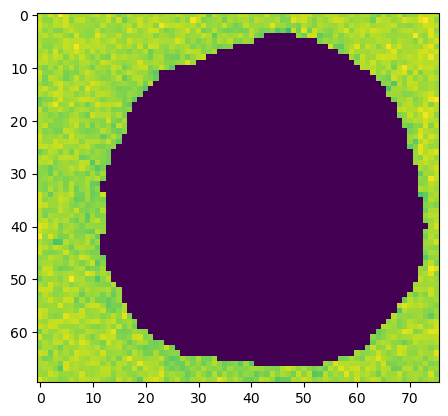

In [97]:
plt.imshow(dist.zproj_background.iloc[0])